In [2]:
#Imports
import numpy as np
import pandas as pd
import os
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [4]:
#Getting the list of files
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/ML')
list_files = listdir_nohidden(datapath)
suffix = [files.split('.')[3] for files in list_files]
#Starter code when we want to use different bands for analysis
file_s = list_files[24]
print file_s

lc_101.21170.2699.B.mjd


In [5]:
filepath = os.path.join(datapath, file_s)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [str(val) for val in lines[2].split(' ')]
    for line in lines[3:]:
        data.append([float(val) for val in line.split(' ')])

In [6]:
data_df = pd.DataFrame(data)
data_df.columns = header

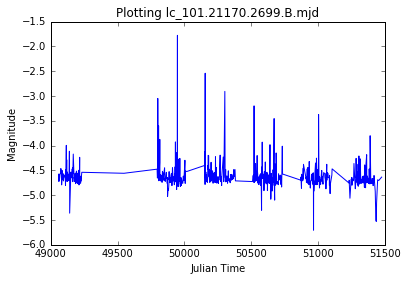

In [7]:
plt.plot(data_df['#MJD'], data_df['Mag'])
plt.xlabel('Julian Time')
plt.ylabel('Magnitude')
plt.title('Plotting '+file_s)
plt.savefig(os.path.join(dirpath,'graphs/microlensy/')\
            +file_s+'.png')

In [20]:
indim = 4
outdim = 1
lstmLayerWidth = 50
data_arr = np.array(data)
time = data_arr[:,0] - data_arr[0,0]
mag = data_arr[:,1]
delta_time = np.lib.pad(np.diff(time), (1,0), 'edge')
derivative = np.divide(np.diff(mag), np.diff(time))
magDerivative = np.lib.pad(derivative, (1,0), 'edge')
resp = np.lib.pad(mag[1:], (0,1), 'edge')
feature_list = [mag, time, delta_time, magDerivative]
feats = np.vstack(feature_list)
ds = SequentialDataSet(indim, outdim)
for feat, res in zip(feats.T, resp):
    ds.addSample(list(feat), res)

In [21]:
cycles_per_file = 200
epochs_per_cycle = 1
net = buildNetwork(indim,lstmLayerWidth,outdim, hiddenclass=LSTMLayer, \
                       outputbias=False, recurrent=True)  

In [10]:
##Error function
def error_in_prediction(predicted_sample, actual_next_sample):
    if type(predicted_sample) is list:
        predicted_sample = np.array(predicted_sample)
    if type(actual_next_sample) is list:
        actual_next_sample = np.array(actual_next_sample)
    error = np.mean(np.square(predicted_sample - actual_next_sample))
    return error

In [24]:
##Plotting function
def gen_state_iteration_plot(lstm_width, state_values, net, ds,\
        it_num, name, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time = []
    for sample, target in ds.getSequenceIterator(0):
        current_input.append(sample[0])
        time.append(sample[1])
        predicted_sample.append(net.activate(sample))
        actual_next_sample.append(target)

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time,current_input, label='Input')
    axarr[0,1].plot(time,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time steps')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time steps')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time steps')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('microlensing_3.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

In [25]:
trainer = RPropMinusTrainer(net, dataset= ds)
train_errors = []
state_values = [[] for k in range(lstmLayerWidth)]
epochs_per_cycle = 1
cycles =1000
epochs = epochs_per_cycle * cycles
for i in xrange(cycles):
    trainer.trainEpochs(epochs_per_cycle)
    train_errors.append(trainer.testOnData())
    epoch = (i+1) * epochs_per_cycle
    #print "\r epoch {}/{}".format(epoch, epochs)
state_values = [[] for k in range(lstmLayerWidth)]
state_val = list(net['hidden0'].state)[:len(data)]
for state in state_val:
    for k in range(lstmLayerWidth):
        state_values[k].append(state[k])
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds, i, 'sin', save=True)

Error in prediction :0.778624061179
